In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false 
#Caleb's magical words to prevent memory error, disables JAX?

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
import keypoint_moseq
import keypoint_moseq as kpms
from keypoint_moseq.io import load_results
print(keypoint_moseq.__version__)#should ONLY print 0.5 version

0.5.0


In [3]:
import os
import glob
import h5py
import pandas as pd
import numpy as np
import copy

In [4]:
#for already trained model, load project directly, config file and pca
project_dir = "/home/nj35/MRes/moseq_project/NOR_model"

In [5]:
config = lambda: kpms.load_config(project_dir)

In [6]:
#load data (e.g from DeepLabCut)
keypoint_data_path = [
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/NOR/crop'
] # can be a file, a directory, or a list of files

# Pre-processing

In [16]:
# Function to find all .h5 files in specified directories
def find_h5_files(keypoint_data_path):
    h5_files = []  
    for directory in keypoint_data_path:
        pattern = os.path.join(directory, '*.h5')  # Look only in the specified folders (no recursion)
        h5_files.extend(glob.glob(pattern))  
    return h5_files

In [17]:
# Get list of .h5 files from the given directories
h5_files = find_h5_files(keypoint_data_path)
print(f"Number of .h5 files found: {len(h5_files)}")
print("Found .h5 files:", h5_files)
#should be 74 for NOR

Number of .h5 files found: 74
Found .h5 files: ['/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 17 - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 1 - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 12  - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 13 - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 14 - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5', '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 15 - cr

In [9]:
# Process each .h5 file: filter and overwrite it in the same location
for h5_file_NOR in h5_files:
    try:
        print(f"Processing: {h5_file_NOR}")

        # Load the existing .h5 file
        df_NOR = pd.read_hdf(h5_file_NOR)

        # Apply filtering: Keep only 'animal0'
        df_filtered_NOR = df_3CT.loc[:, df_NOR.columns.get_level_values('individuals') == 'animal0']

        # Overwrite the same file with filtered data
        df_filtered_NOR.to_hdf(h5_file_NOR, key='df', mode='w')

        print(f"Filtered and saved: {h5_file_NOR}")

    except Exception as e:
        print(f"Error processing {h5_file_NOR}: {e}")

Processing: /home/nj35/MRes/TDP videos/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 17 - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5
Error processing /home/nj35/MRes/TDP videos/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 17 - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5: name 'df_3CT' is not defined
Processing: /home/nj35/MRes/TDP videos/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 1 - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5
Error processing /home/nj35/MRes/TDP videos/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 1 - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5: name 'df_3CT' is not defined
Processing: /home/nj35/MRes/TDP videos/pre-induction/NOR/crop/pre-induction-NOR-crop_fixed_Trial 12  - crop_superanimal_topviewmouse_snapshot-detector-004_snapshot-004.h5
Error processing /home/nj35/MRes/TDP videos/pre-induction/NOR/crop/pre-induction-

# NOR model

In [18]:
# Define bodyparts and skeleton
bodyparts = [
    'nose', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip',
    'left_eye', 'right_eye', 'neck', 'mid_back', 'mouse_center',
    'mid_backend', 'mid_backend2', 'mid_backend3', 'tail_base',
    'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'left_shoulder',
    'left_midside', 'left_hip', 'right_shoulder', 'right_midside',
    'right_hip', 'tail_end', 'head_midpoint'
]

skeleton = [
    ['nose', 'left_eye'],
    ['nose', 'right_eye'],
    ['nose', 'left_ear'],
    ['nose', 'right_ear'],
    ['left_eye', 'right_eye'],
    ['left_ear', 'left_ear_tip'],
    ['right_ear', 'right_ear_tip'],
    ['left_ear', 'head_midpoint'],
    ['right_ear', 'head_midpoint'],
    ['neck', 'left_shoulder'],
    ['neck', 'right_shoulder'],
    ['neck', 'mid_back'],
    ['left_shoulder', 'left_hip'],
    ['right_shoulder', 'right_hip'],
    ['left_hip', 'left_midside'],
    ['right_hip', 'right_midside'],
    ['left_midside', 'mid_back'],
    ['right_midside', 'mid_back'],
    ['mid_back', 'mouse_center'],
    ['mouse_center', 'mid_backend'],
    ['mouse_center', 'mid_backend2'],
    ['mouse_center', 'mid_backend3'],
    ['mid_backend', 'mid_backend2'],
    ['mid_backend2', 'mid_backend3'],
    ['mid_backend2', 'tail_base'],
    ['mid_backend3', 'tail_base'],
    ['tail_base', 'tail1'],
    ['tail1', 'tail2'],
    ['tail2', 'tail3'],
    ['tail3', 'tail4'],
    ['tail4', 'tail5'],
    ['tail5', 'tail_end'],
    ['head_midpoint', 'neck']
]

In [19]:
video_dir = [
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/NOR/crop'
]

In [20]:
# Set up the project
kpms.setup_project(
    overwrite=True,
    project_dir=project_dir, # decides where demo project is created
    video_dir=video_dir,
    bodyparts=bodyparts,
    skeleton=skeleton
)

In [21]:
kpms.update_config(
    project_dir,
    video_dir=[
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/NOR/crop'],
    anterior_bodyparts=["nose"],
    posterior_bodyparts=["tail_base"],
    use_bodyparts = [
    "nose",
    "head_midpoint",
    "left_ear",
    "right_ear",
    "neck",
    "mid_back",
    "mouse_center",
    "mid_backend2",
    "tail_base"],
)

In [16]:
### Caleb's advice for excluding likelihoods <0.3 including when mouse in in dark and not recognised

coordinates, confidences, bodyparts = kpms.load_keypoints(keypoint_data_path, 'deeplabcut', recursive=False, extension='.h5')

coordinates = {k : np.where(confidences[k][:,:,None] < 0.3, np.nan, coordinates[k]) for k in coordinates} #changes values less than 0.6 to NaN

data, metadata = kpms.format_data(coordinates, confidences, **config()) #format data for analysing

Loading keypoints: 100%|████████████████| 74/74 [00:03<00:00, 20.68it/s]


>=90.0% of variance exlained by 5 components.


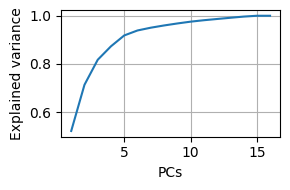

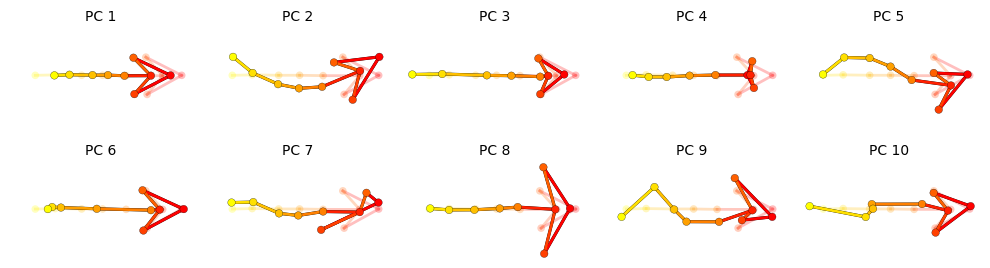

In [9]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

In [24]:
kpms.update_config(project_dir, latent_dim=5)

In [10]:
model = kpms.init_model(data, pca=pca, **config())

Outputs will be saved to
/home/nj35/MRes/moseq_project/NOR_model/2025_04_26-13_37_50


 49%|█████████████████▏                 | 25/51 [02:10<02:13,  5.14s/it]

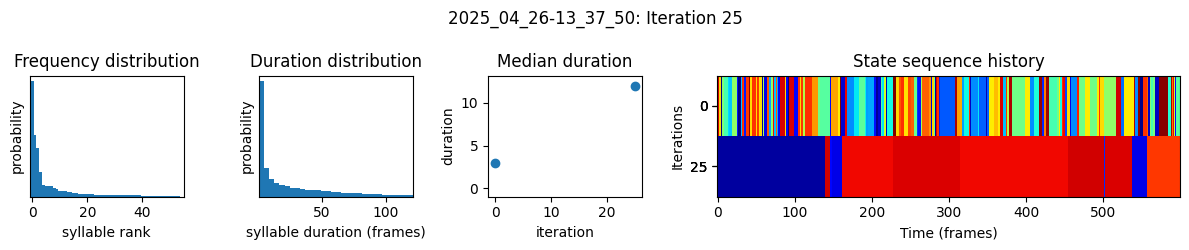

 98%|██████████████████████████████████▎| 50/51 [04:20<00:05,  5.13s/it]

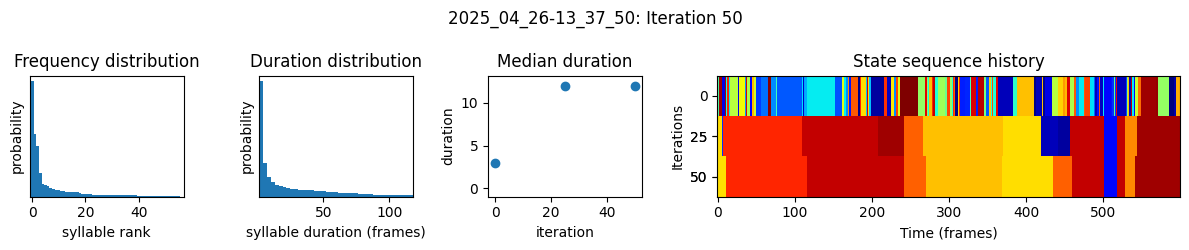

100%|███████████████████████████████████| 51/51 [04:26<00:00,  5.22s/it]


In [11]:
# optionally modify kappa
model = kpms.update_hypparams(model, kappa=5e6) #originally 1e4 for 20 median frames at 50 fps = 400ms syllable duration. 2e4 is 800ms?

num_ar_iters = 50

model, model_name = kpms.fit_model( #you can change model_name for AR-HMM which links to full model
    model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters)


In [13]:
# load model_1e7_5e6 checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name="model_5e6_1e6")

Outputs will be saved to
/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6


  5%|█▌                              | 25/501 [05:13<1:31:27, 11.53s/it]

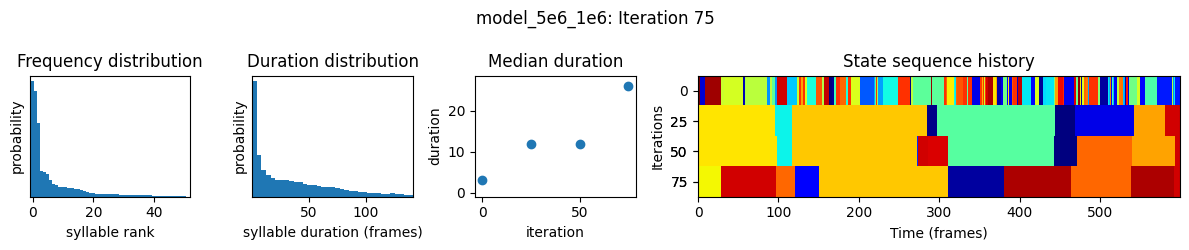

 10%|███▏                            | 50/501 [10:03<1:26:53, 11.56s/it]

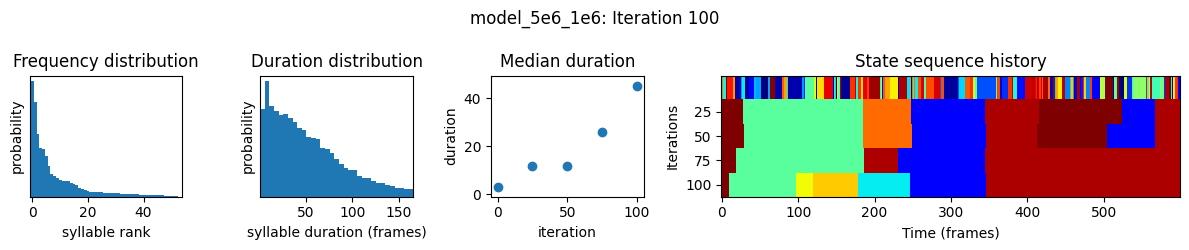

 15%|████▊                           | 75/501 [14:52<1:21:59, 11.55s/it]

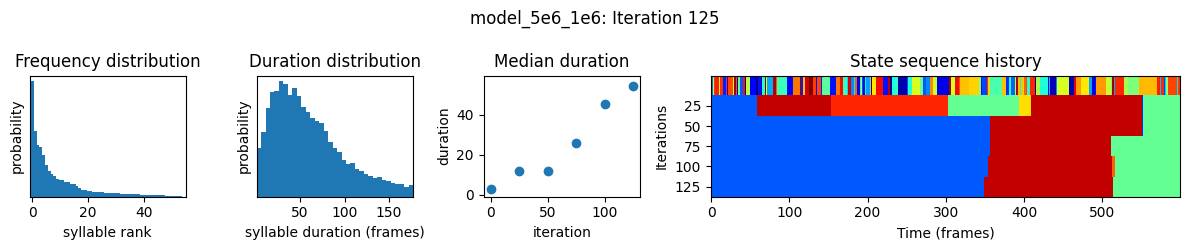

 20%|██████▏                        | 100/501 [19:41<1:17:11, 11.55s/it]

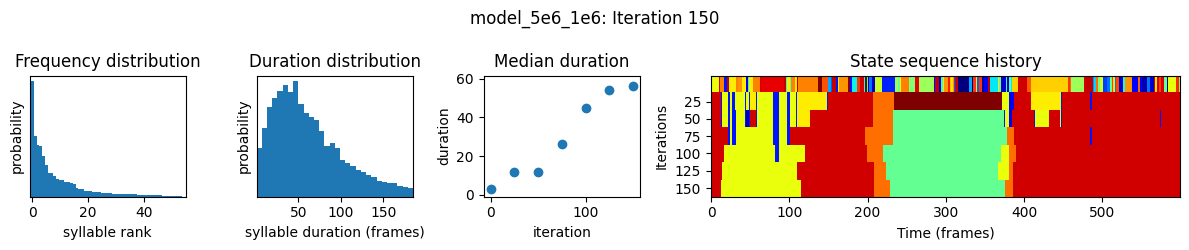

 25%|███████▋                       | 125/501 [24:31<1:12:23, 11.55s/it]

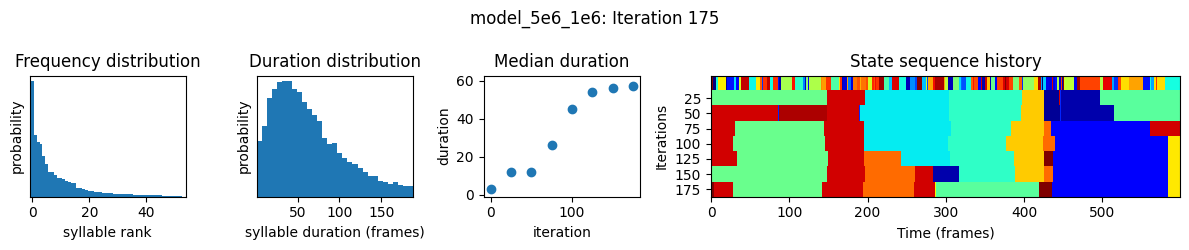

 30%|█████████▎                     | 150/501 [29:21<1:07:30, 11.54s/it]

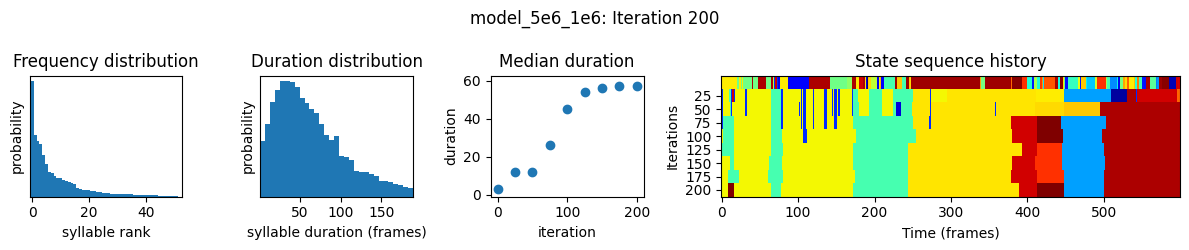

 35%|██████████▊                    | 175/501 [34:10<1:02:43, 11.54s/it]

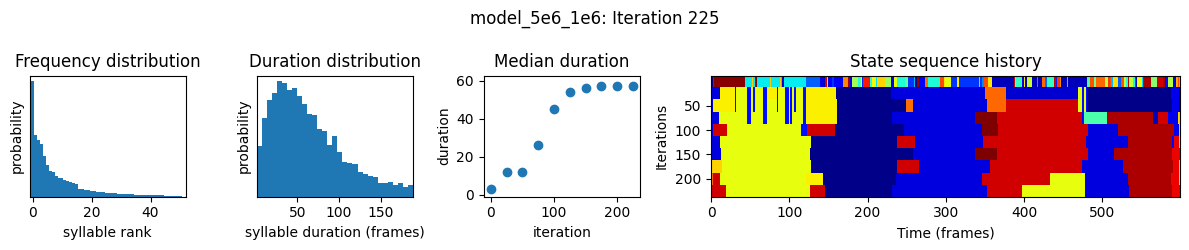

 40%|█████████████▏                   | 200/501 [39:00<57:52, 11.54s/it]

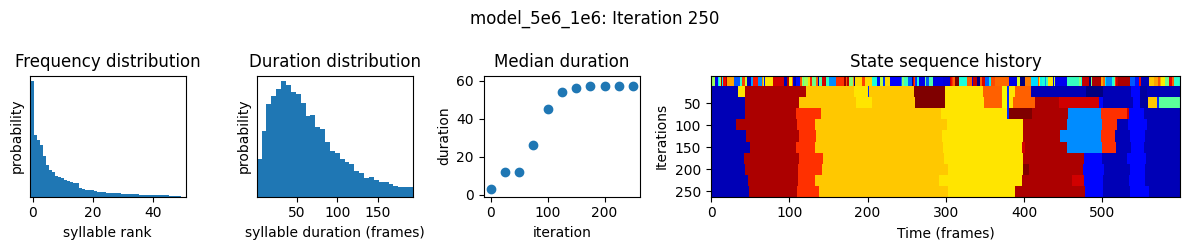

 45%|██████████████▊                  | 225/501 [43:49<53:07, 11.55s/it]

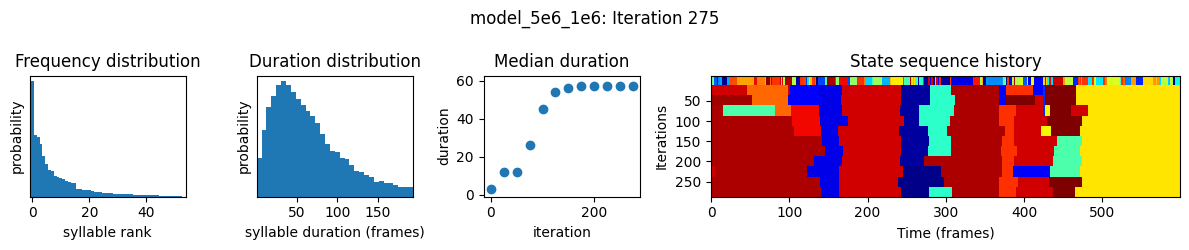

 50%|████████████████▍                | 250/501 [48:39<48:22, 11.57s/it]

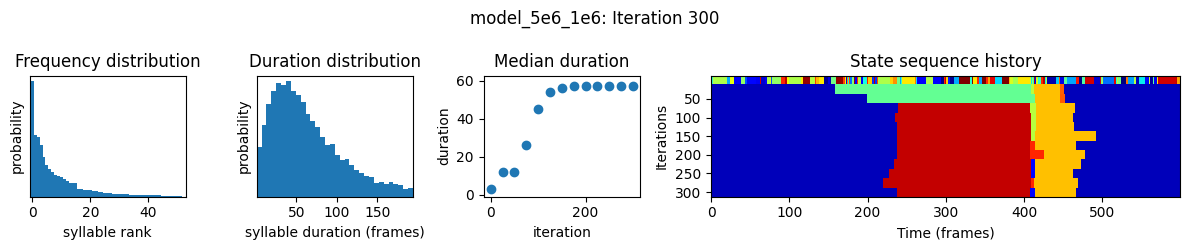

 55%|██████████████████               | 275/501 [53:28<43:26, 11.53s/it]

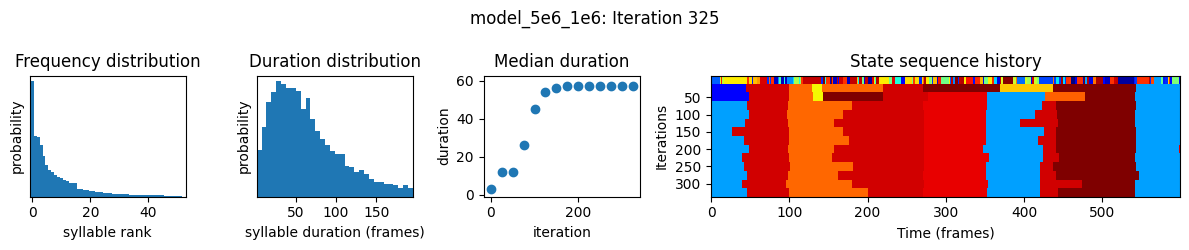

 60%|███████████████████▊             | 300/501 [58:18<38:38, 11.54s/it]

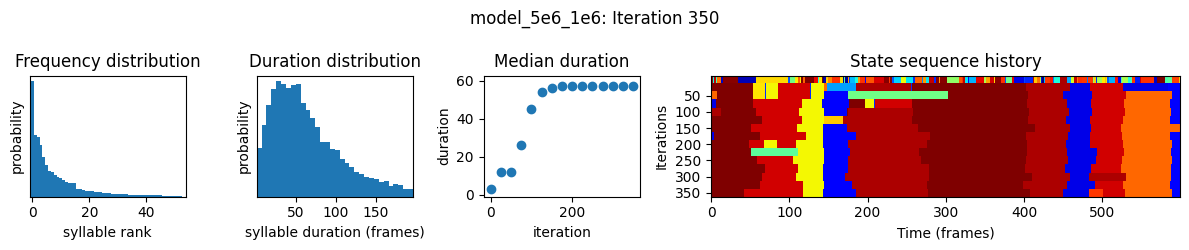

 65%|████████████████████           | 325/501 [1:03:07<33:51, 11.54s/it]

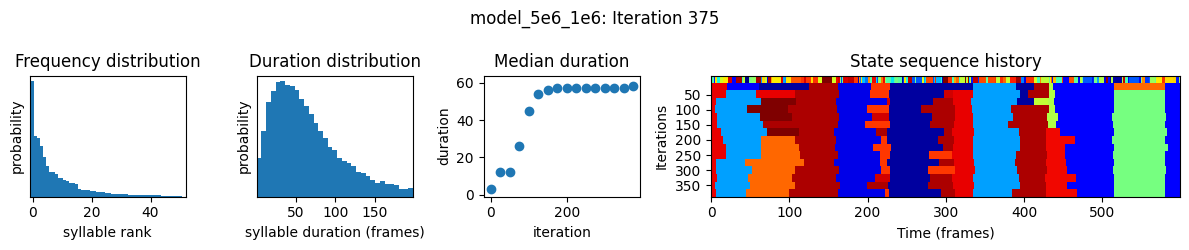

 70%|█████████████████████▋         | 350/501 [1:07:57<29:02, 11.54s/it]

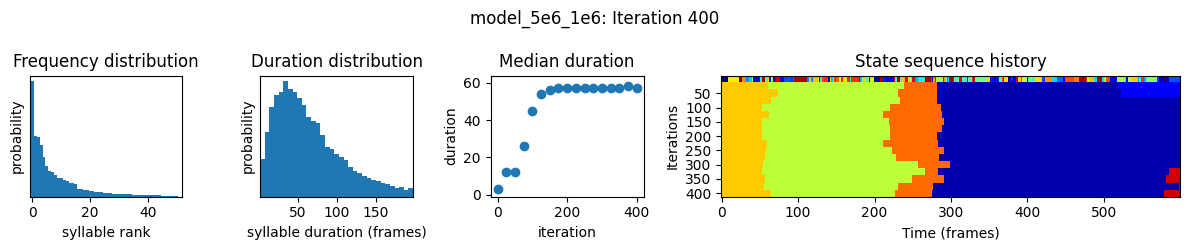

 75%|███████████████████████▏       | 375/501 [1:12:47<24:14, 11.54s/it]

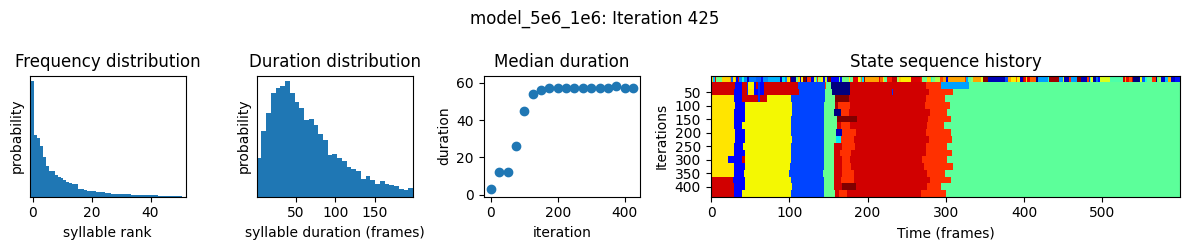

 80%|████████████████████████▊      | 400/501 [1:17:36<19:24, 11.53s/it]

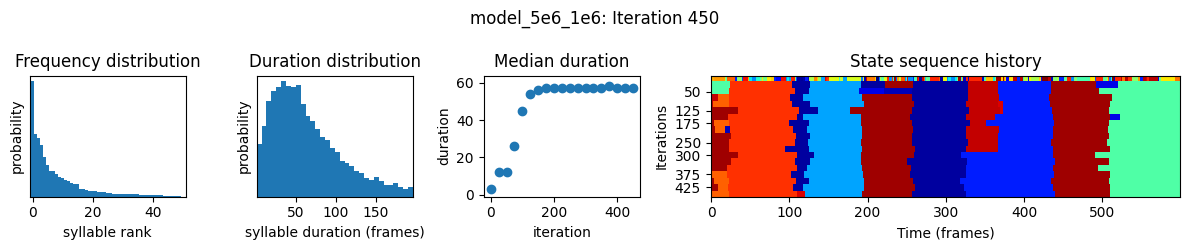

 85%|██████████████████████████▎    | 425/501 [1:22:26<14:36, 11.53s/it]

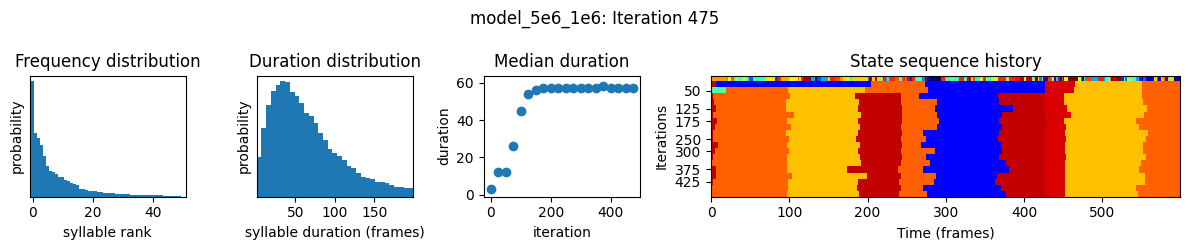

 90%|███████████████████████████▊   | 450/501 [1:27:16<09:48, 11.54s/it]

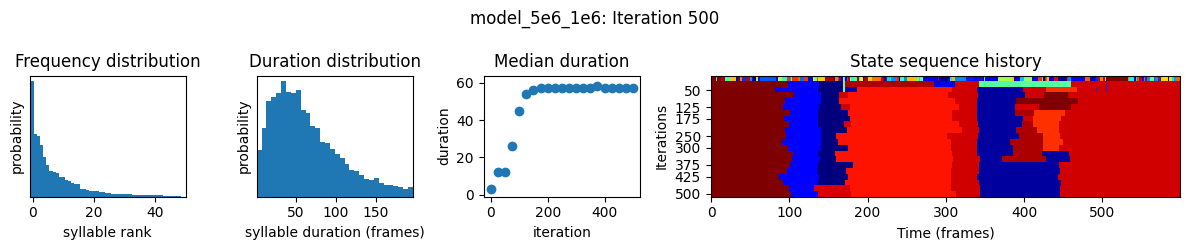

 95%|█████████████████████████████▍ | 475/501 [1:32:05<04:59, 11.53s/it]

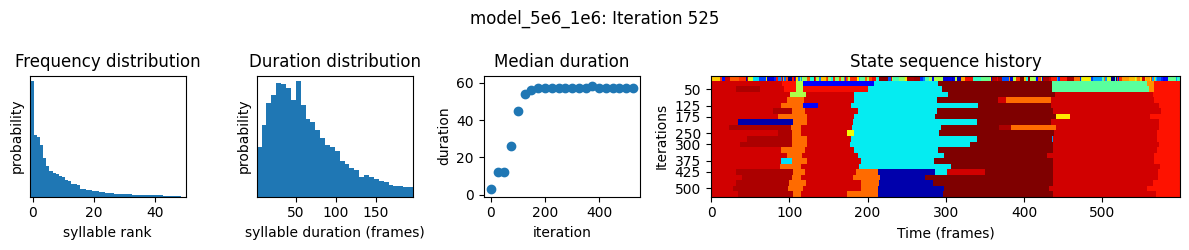

100%|██████████████████████████████▉| 500/501 [1:36:55<00:11, 11.54s/it]

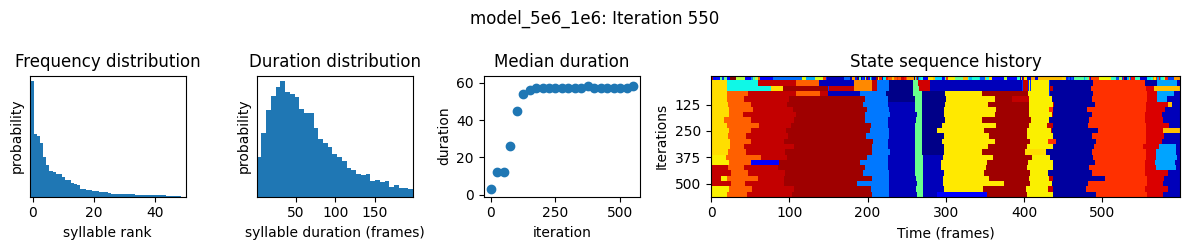

100%|███████████████████████████████| 501/501 [1:37:08<00:00, 11.63s/it]


In [14]:
# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e6)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name="model_5e6_1e6", ar_only=False, #2e4 in this line refers to AR-HMM model
    start_iter=current_iter, num_iters=current_iter+500)[0]

In [15]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name="model_5e6_1e6");

Reindexing: 100%|███████████| 23/23 [00:10<00:00,  2.14model snapshot/s]


In [8]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name="model_5e6_1e6")

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name="model_5e6_1e6")

Saved results to
/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/results.h5


Saving trajectory plots to /home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/trajectory_plots


Generating trajectory plots: 100%|██████| 26/26 [00:11<00:00,  2.21it/s]


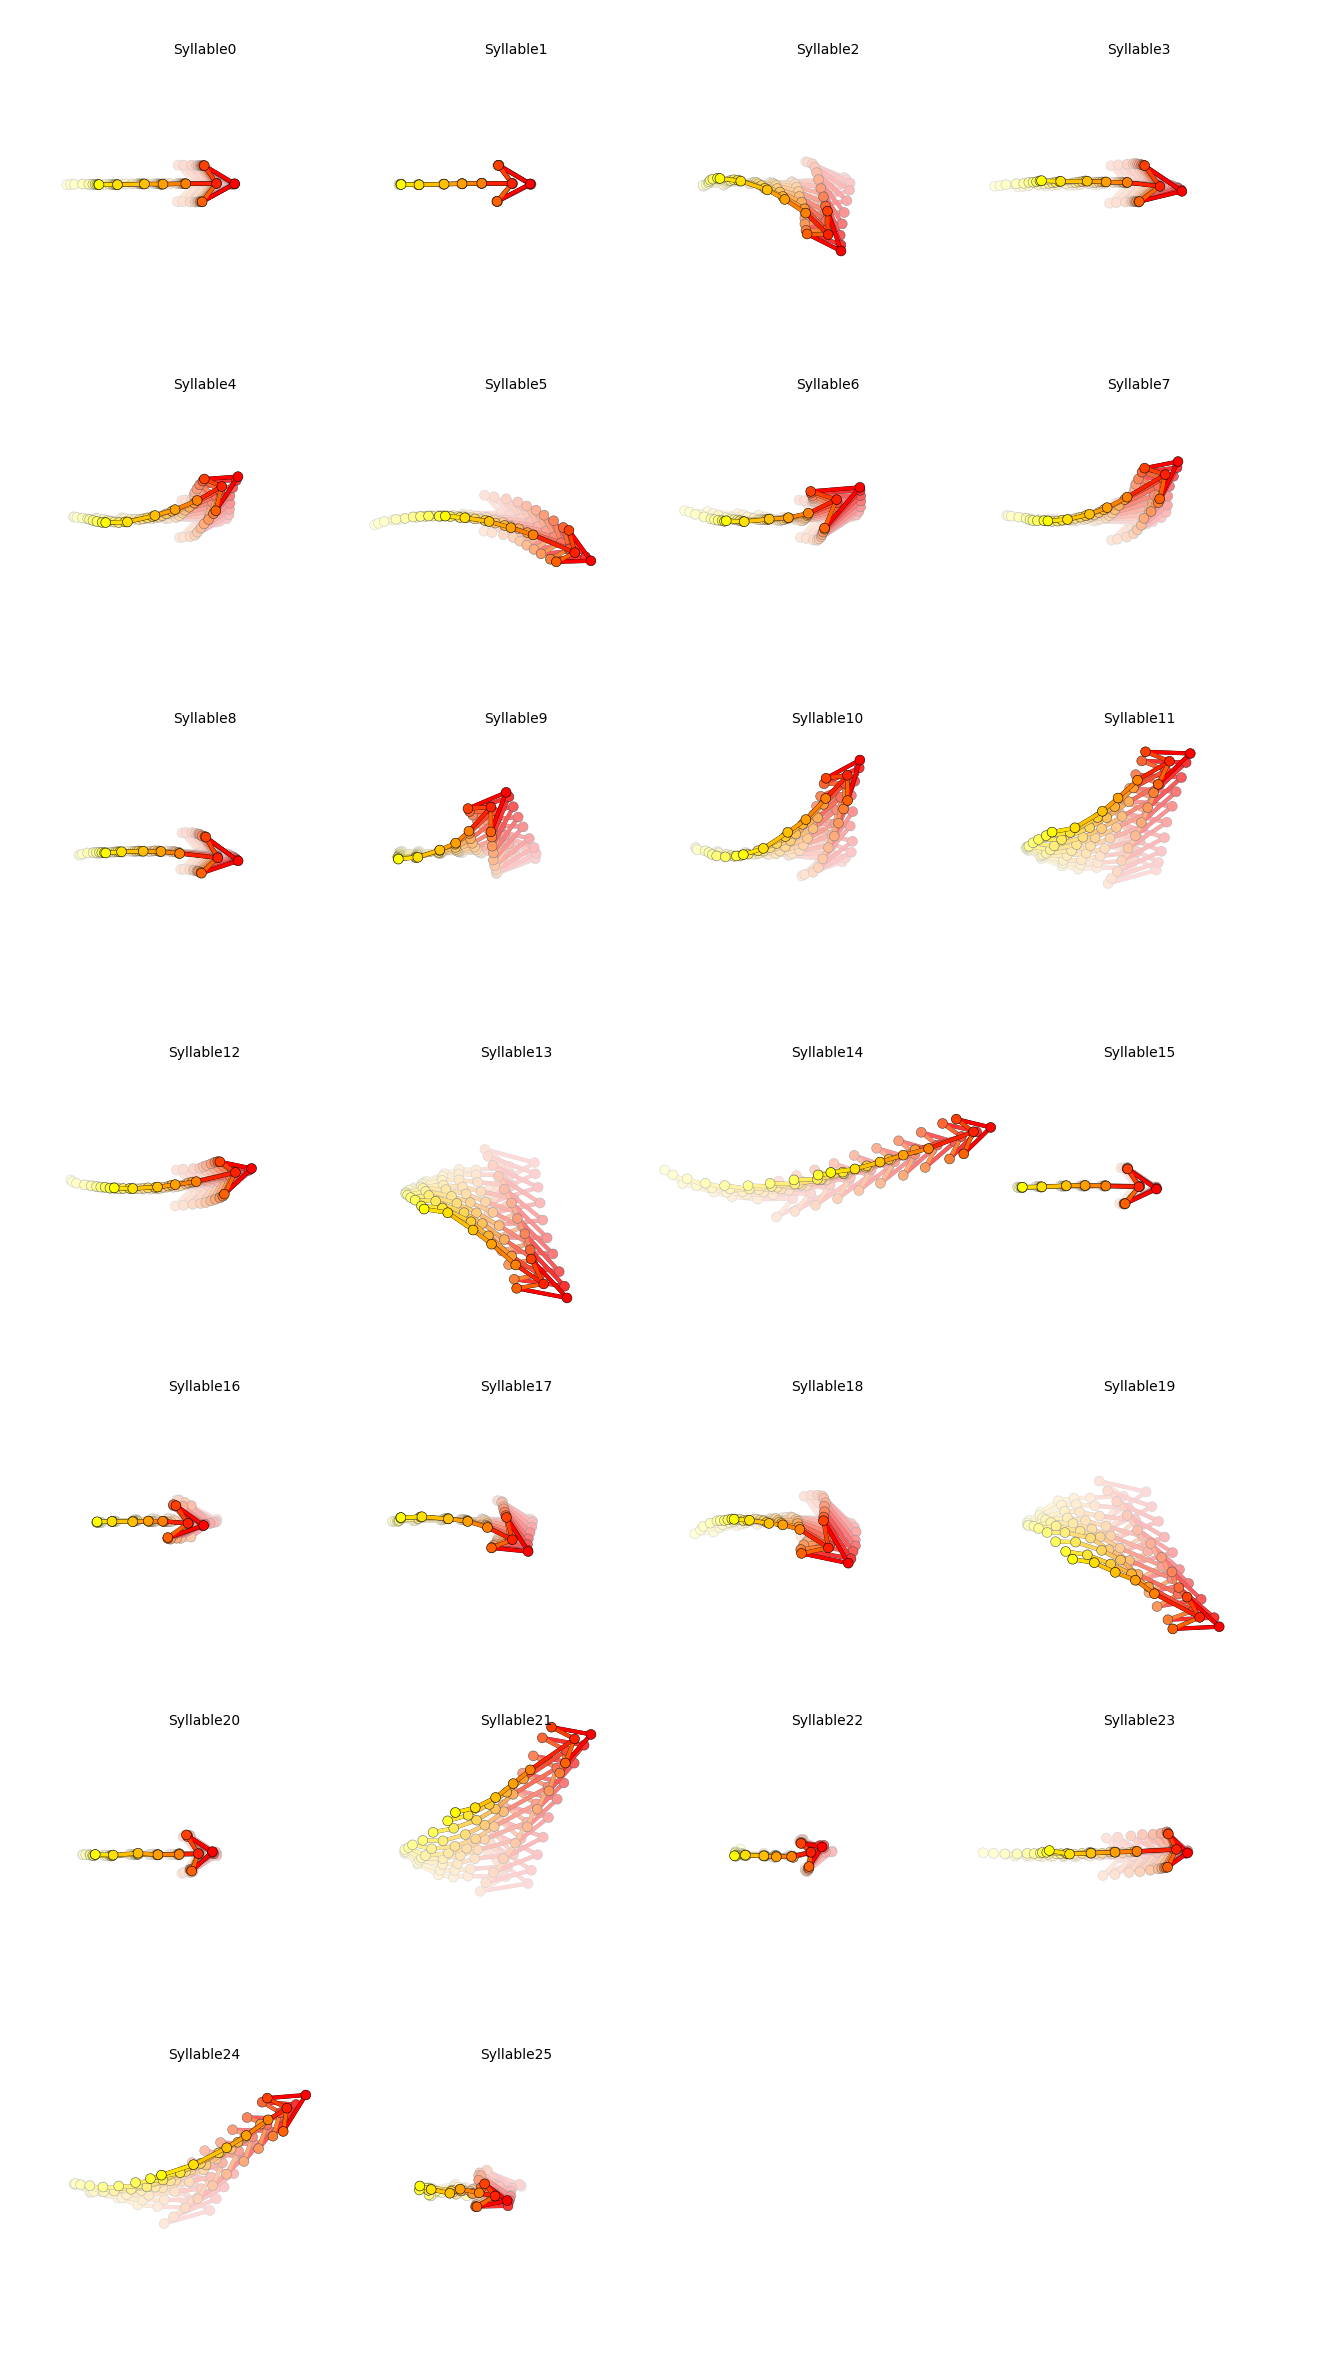

In [17]:
results = kpms.load_results(project_dir, model_name="model_5e6_1e6")
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name="model_5e6_1e6",  density_sample=False, **config())

In [18]:
kpms.generate_grid_movies(
    results, 
    project_dir, 
    model_name="model_5e6_1e6", 
    coordinates=coordinates, 
    pre=50, 
    post=100, 
    **config()
);

Writing grid movies to /home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/grid_movies


/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/keypoint_moseq/viz.py:1282: UserWarning:


Videos will be downscaled by a factor of 0.62 so that the grid movies
are under 1920 pixels. Use `max_video_size` to increase or decrease
this size limit.





Using window size of 512 pixels


Generating grid movies: 100%|███████████| 26/26 [05:11<00:00, 11.99s/it]


Saving dendrogram plot to /home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/similarity_dendrogram


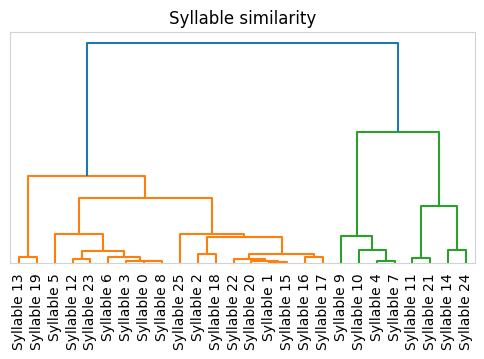

In [17]:
# Plot a dendrogram representing distances between each syllable’s median trajectory.
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name="model_5e6_1e6", **config())

In [20]:
kpms.interactive_group_setting(project_dir, model_name="model_5e6_1e6")

Row
    [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'name': 'recording name',...}, value=              ..., widths={'name': 400})
    [1] Column
        [0] Button(button_type='primary', name='Save group info')

In [18]:
moseq_NOR = kpms.compute_moseq_df(project_dir, model_name="model_5e6_1e6", fps=50, smooth_heading=True) 
moseq_NOR

,name,centroid_x,centroid_y,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset
0,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,100.463064,715.804753,1.318493,0.000000,0.000000,0,0,post_w1,True
1,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,100.332196,712.697147,1.318493,0.005488,155.518026,0,1,post_w1,False
2,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,100.068108,709.325445,1.316600,0.015481,169.101396,0,2,post_w1,False
3,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,101.736587,707.790776,1.314803,0.033272,113.347163,0,3,post_w1,False
4,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,102.610759,708.140886,1.316600,0.059850,47.083826,0,4,post_w1,False
...,...,...,...,...,...,...,...,...,...,...
1109077,pre-induction_NOR_trial_8_superanimal_topviewm...,265.507119,689.176984,1.066794,1.913138,22.035793,31,15020,control,False
1109078,pre-induction_NOR_trial_8_superanimal_topviewm...,264.906179,691.944425,1.071857,1.417053,141.596814,31,15021,control,False
1109079,pre-induction_NOR_trial_8_superanimal_topviewm...,264.490253,693.943425,1.101964,0.974588,102.090570,31,15022,control,False
1109080,pre-induction_NOR_trial_8_superanimal_topviewm...,260.654843,695.590297,1.101964,0.600465,208.701714,31,15023,control,False


In [19]:
# summary statistics for each syllable in each recording session, 
# such as its usage frequency and its distribution of kinematic parameters.

model_name='model_5e6_1e6'

moseq_NOR_stats = kpms.compute_stats_df(
    project_dir,
    'model_5e6_1e6',
    moseq_NOR, #change to df created in step before
    groupby=['group', 'name'],
    min_frequency=0.005, # threshold frequency for including a syllable in the dataframe# column(s) to group the dataframe by
    fps=50) # frame rate of the video from which keypoints were inferred                    

moseq_NOR_stats

,group,name,syllable,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,angular_velocity_max,velocity_px_s_mean,velocity_px_s_std,velocity_px_s_min,velocity_px_s_max,frequency,duration
0,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,0,0.406258,1.723065,-3.140288,3.136453,-0.292110,15.683260,-313.996365,314.007865,105.380355,98.994711,0.511101,596.991234,0.163462,1.413529
1,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,1,0.355987,1.233824,-2.669181,1.657456,-0.142845,0.437000,-3.101861,0.849530,38.943370,22.909210,1.974567,175.633420,0.043269,1.146667
2,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,2,0.043983,1.571973,-3.123952,3.070018,1.128947,11.383554,-312.149008,6.014906,194.526993,121.954439,5.862394,560.670369,0.110577,0.668696
3,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,3,-0.041235,1.576956,-3.140476,3.140373,-0.021375,14.268867,-313.789516,312.767550,113.178780,88.335949,2.801872,533.297204,0.139423,2.000690
4,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,4,-0.001845,1.710296,-3.122716,3.138936,-0.110250,12.244606,-5.567275,312.640265,184.627801,133.020251,2.926173,635.741108,0.067308,1.890000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,post_w2,post_w2_NOR_trial_2_(cohort_2)_superanimal_top...,19,0.529700,1.739205,-3.089944,3.119318,-0.274725,15.761972,-312.503693,4.639248,287.173468,154.681025,17.272478,738.122862,0.026455,1.588000
1515,post_w2,post_w2_NOR_trial_2_(cohort_2)_superanimal_top...,21,-0.859702,2.534868,-3.140360,3.141192,0.201165,21.164930,-6.401378,311.755018,331.137481,181.779057,24.343411,724.187866,0.031746,0.733333
1516,post_w2,post_w2_NOR_trial_2_(cohort_2)_superanimal_top...,22,-1.103364,1.345586,-3.058339,3.134253,0.009157,44.222723,-313.380022,313.030476,65.118572,30.304885,3.008882,166.571644,0.021164,0.510000
1517,post_w2,post_w2_NOR_trial_2_(cohort_2)_superanimal_top...,23,0.084383,2.950533,-3.138452,3.140262,4.809140,58.024056,-313.961285,313.454029,144.669737,127.923896,1.046904,508.776616,0.010582,1.170000


In [20]:
# optional
#save moseq dataframe
save_dir0 = '/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6'
moseq_NOR.to_csv('/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/moseq_NOR.csv', index=False)
print('Saved `moseq_NOR` dataframe to', save_dir0)

Saved `moseq_NOR` dataframe to /home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6


In [21]:
#save moseq stats_df
save_dir1 = '/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6'
moseq_NOR_stats.to_csv('/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/moseq_NOR_stats.csv', index=False)
print('Saved `moseq_NOR_stats` dataframe to', save_dir1)

Saved `moseq_NOR_stats` dataframe to /home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6


In [25]:
kpms.label_syllables(project_dir, model_name= "model_5e6_1e6", moseq_df=moseq_NOR)

Row
    [0] Column
        [0] Select(options=[0, 1, 2, 3, 4, ...], value=0)
        [1] ParamFunction(function, _pane=Video)
    [1] Column
        [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'syllable': 'syllable', ...}, value=    syllable l..., widths={'syllable': 100})
        [1] Column
            [0] Button(button_type='primary', name='Save syllable info')

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Saved figure to /home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/figures/frequency_stat_stats.png


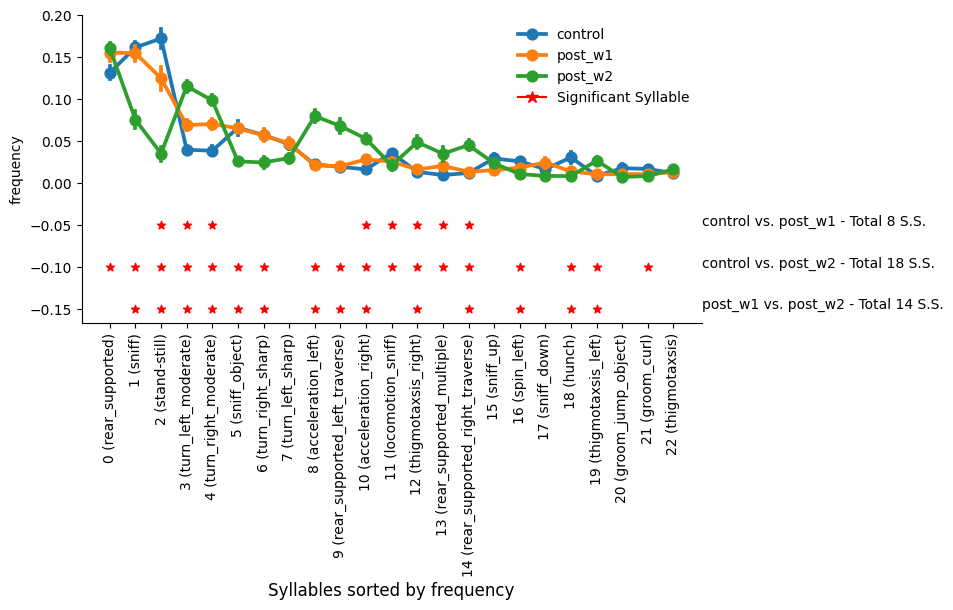

In [11]:
model_name="model_5e6_1e6"

kpms.plot_syll_stats_with_sem(
    moseq_NOR_stats,
    project_dir,
    model_name,
    plot_sig=True,  # whether to mark statistical significance with a star
    thresh=0.05,  # significance threshold
    stat="frequency",  # statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order="stat",  # order syllables by overall frequency ("stat") or degree of difference ("diff")
    #ctrl_group="a",  # name of the control group for statistical testing
    #exp_group="b",  # name of the experimental group for statistical testing
    figsize=(8, 4),  # figure size
    groups=moseq_NOR_stats["group"].unique(),  # groups to be plotted
);

In [ ]:
#Add cohort 2+3 new data
#When running "apply_model",  we recommend applying to both the new and old data, so for now you can fix both issues by 
#(1) applying the model to all your data (new and old); (2) deleting the old index file.

In [9]:
#load data (e.g from DeepLabCut)
new_data_nor = [
    '/home/nj35/MRes/TDP videos/Cohort 1/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 1/post-induction-w2/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/pre-induction/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w1/NOR/crop',
    '/home/nj35/MRes/TDP videos/Cohort 3/post-induction-w2/NOR/crop'
] # can be a file, a directory, or a list of files

In [9]:
# Function to find all .h5 files in specified directories
def find_h5_files(new_data_nor):
    h5_files = []  
    for directory in new_data_nor:
        pattern = os.path.join(directory, '*.h5')  # Look only in the specified folders (no recursion)
        h5_files.extend(glob.glob(pattern))  
    return h5_files

In [ ]:
# Get list of .h5 files from the given directories
h5_files = find_h5_files(new_data_nor)
print(f"Number of .h5 files found: {len(h5_files)}")
print("Found .h5 files:", h5_files)
#should be 74 for OFT

In [ ]:
# Process each .h5 file: filter and overwrite it in the same location
for h5_file_nor in h5_files:
    try:
        print(f"Processing: {h5_file_nor}")

        # Load the existing .h5 file
        df_nor = pd.read_hdf(h5_file_nor)

        # Apply filtering: Keep only 'animal0'
        df_filtered_nor = df_nor.loc[:, df_nor.columns.get_level_values('individuals') == 'animal0']

        # Overwrite the same file with filtered data
        df_filtered_nor.to_hdf(h5_file_nor, key='df', mode='w')

        print(f"Filtered and saved: {h5_file_nor}")

    except Exception as e:
        print(f"Error processing {h5_file_nor}: {e}")

In [26]:
# load the most recent model checkpoint and pca object
model = kpms.load_checkpoint(project_dir, model_name="model_5e6_1e6")[0]

In [10]:
### Caleb's advice for excluding likelihoods <0.3 including when mouse in in dark and not recognised

coordinates, confidences, bodyparts = kpms.load_keypoints(new_data_nor, 'deeplabcut', recursive=False, extension='.h5')

coordinates = {k : np.where(confidences[k][:,:,None] < 0.3, np.nan, coordinates[k]) for k in coordinates} #changes values less than 0.6 to NaN
#format data
data, metadata = kpms.format_data(coordinates, confidences, **config()) #format data for analysing

Loading keypoints: 100%|████████████████| 74/74 [00:03<00:00, 20.02it/s]


In [29]:
# apply saved model to new data
results = kpms.apply_model(model, data, metadata, project_dir, model_name="model_5e6_1e6", **config())

Applying model: 100%|███████████████| 500/500 [1:18:47<00:00,  9.45s/it]


Saved results to
/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/results.h5


In [12]:
# optionally rerun `save_results_as_csv` to export the new results
kpms.save_results_as_csv(results, project_dir, model_name="model_5e6_1e6")

Saving to csv: 100%|████████████████████| 50/50 [00:02<00:00, 17.30it/s]


In [30]:
kpms.interactive_group_setting(project_dir, model_name="model_5e6_1e6")

Row
    [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'name': 'recording name',...}, value=              ..., widths={'name': 400})
    [1] Column
        [0] Button(button_type='primary', name='Save group info')

In [11]:
moseq_NOR_new = kpms.compute_moseq_df(project_dir, model_name="model_5e6_1e6", fps=50, smooth_heading=True) 
moseq_NOR_new

,name,centroid_x,centroid_y,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset
0,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,99.973747,708.063941,1.309460,0.000000,0.000000,1,0,post_w1,True
1,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,99.593965,708.394397,1.309460,0.006250,25.171181,1,1,post_w1,False
2,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,99.817686,708.249808,1.338274,0.016034,13.318904,1,2,post_w1,False
3,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,100.953171,708.229387,1.309460,0.033822,56.783396,1,3,post_w1,False
4,post-induction-w1-NOR-fixed_Trial 1 - crop_sup...,101.575537,708.328824,1.309460,0.063581,31.512984,1,4,post_w1,False
...,...,...,...,...,...,...,...,...,...,...
1109077,pre-induction_NOR_trial_8_superanimal_topviewm...,264.623075,689.376888,1.061525,1.874204,48.706523,39,15020,control,False
1109078,pre-induction_NOR_trial_8_superanimal_topviewm...,264.765005,691.921271,1.074762,1.389349,127.416938,39,15021,control,False
1109079,pre-induction_NOR_trial_8_superanimal_topviewm...,264.306967,693.365344,1.092730,0.955043,75.748666,39,15022,control,False
1109080,pre-induction_NOR_trial_8_superanimal_topviewm...,259.928383,695.086918,1.092730,0.587396,235.243585,39,15023,control,False


In [12]:
# summary statistics for each syllable in each recording session, 
# such as its usage frequency and its distribution of kinematic parameters.

model_name='model_5e6_1e6'

moseq_NOR_stats_new = kpms.compute_stats_df(
    project_dir,
    'model_5e6_1e6',
    moseq_NOR_new, #change to df created in step before
    groupby=['group', 'name'],
    min_frequency=0.005, # threshold frequency for including a syllable in the dataframe# column(s) to group the dataframe by
    fps=50) # frame rate of the video from which keypoints were inferred                    

moseq_NOR_stats_new

,group,name,syllable,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,angular_velocity_max,velocity_px_s_mean,velocity_px_s_std,velocity_px_s_min,velocity_px_s_max,frequency,duration
0,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,0,0.237063,1.578354,-3.140468,3.137422,0.029835,11.954321,-313.808800,312.691419,118.175201,97.985049,2.085395,537.534281,0.207071,1.683902
1,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,1,0.073126,1.505849,-2.581337,3.113143,-0.060551,0.813399,-3.492693,4.065759,96.205088,105.339260,1.838695,584.414390,0.111111,1.667273
2,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,2,-0.012543,1.501026,-2.862159,2.734371,-0.034333,0.403736,-2.516196,0.845865,98.096419,130.529296,1.433045,500.197719,0.045455,0.897778
3,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,3,0.858275,1.658617,-3.130069,3.140985,0.812590,26.229320,-6.460350,312.750857,249.235173,150.264994,10.305959,685.684522,0.085859,0.667059
4,control,pre-induction-NOR-crop_fixed_Trial 1 - crop_su...,4,0.290468,1.640915,-3.073234,2.958081,1.232900,1.407378,-2.793769,5.895430,171.932276,112.292032,4.209204,585.893156,0.070707,1.102857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,post_w2,post_w2_NOR_trial_2_(cohort_2)_superanimal_top...,16,0.190589,0.832333,-0.920141,2.327330,-2.341383,1.933821,-6.246164,0.316038,266.138686,130.488919,5.187638,483.193842,0.005618,1.380000
1348,post_w2,post_w2_NOR_trial_2_(cohort_2)_superanimal_top...,18,-0.402397,0.114579,-0.545888,-0.265606,0.001364,1.346365,-1.447258,3.570738,55.211566,27.213605,23.087957,122.481346,0.005618,0.520000
1349,post_w2,post_w2_NOR_trial_2_(cohort_2)_superanimal_top...,19,1.474078,1.396296,-3.053892,3.054588,0.287098,19.861120,-4.737669,310.692231,196.582944,141.760097,9.472065,633.031348,0.022472,1.240000
1350,post_w2,post_w2_NOR_trial_2_(cohort_2)_superanimal_top...,20,-1.563908,1.645030,-3.054121,3.131800,-1.164491,8.576129,-15.701296,24.085947,81.678819,44.630604,13.891759,175.839643,0.061798,0.096364


In [13]:
# optional
#save moseq dataframe
save_dir0 = '/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6'
moseq_NOR_new.to_csv('/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/moseq_NOR_new.csv', index=False)
print('Saved `moseq_NOR_new` dataframe to', save_dir0)

Saved `moseq_NOR_new` dataframe to /home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6


In [14]:
#save moseq stats_df
save_dir1 = '/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6'
moseq_NOR_stats_new.to_csv('/home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/moseq_NOR_stats_new.csv', index=False)
print('Saved `moseq_NOR_stats_new` dataframe to', save_dir1)

Saved `moseq_NOR_stats_new` dataframe to /home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6


/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/nj35/miniforge3/envs/keypoint_moseq/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Saved figure to /home/nj35/MRes/moseq_project/NOR_model/model_5e6_1e6/figures/frequency_stat_stats.png


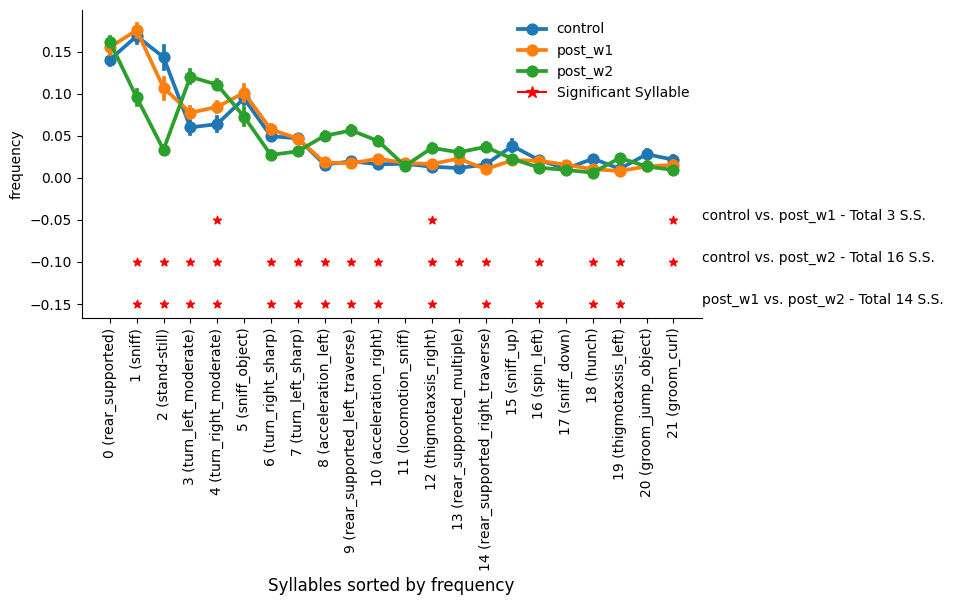

In [35]:
model_name="model_5e6_1e6"

kpms.plot_syll_stats_with_sem(
    moseq_NOR_stats_new,
    project_dir,
    model_name,
    plot_sig=True,  # whether to mark statistical significance with a star
    thresh=0.05,  # significance threshold
    stat="frequency",  # statistic to be plotted (e.g. 'duration' or 'velocity_px_s_mean')
    order="stat",  # order syllables by overall frequency ("stat") or degree of difference ("diff")
    #ctrl_group="a",  # name of the control group for statistical testing
    #exp_group="b",  # name of the experimental group for statistical testing
    figsize=(8, 4),  # figure size
    groups=moseq_NOR_stats_new["group"].unique(),  # groups to be plotted
);